Deep Learning lab04 assignment submission by Arnav Aditya, Roll no.-2210110189

In [ ]:
#@title Install dependencies (run in Colab; skip if running locally with torch already installed)
try:
    import torch
except Exception:
    !pip install -q torch torchvision tqdm matplotlib
print('Ready')


Ready


In [ ]:
import os, random
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


Device: cuda


In [9]:
!nvidia-smi

Fri Sep 12 06:32:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |     184MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Model, training & utilities

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dims=[512,256], num_classes=10, dropout_p=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            if dropout_p and dropout_p > 0.0:
                layers.append(nn.Dropout(p=dropout_p))
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def get_data_loaders(batch_size=128, val_split=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    val_len = int(len(dataset) * val_split)
    train_len = len(dataset) - val_len
    train_set, val_set = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    losses = []
    correct = 0
    total = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return np.mean(losses), correct / total

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    correct = 0
    total = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return np.mean(losses), correct / total

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.wait = 0
        self.should_stop = False
        self.best_state = None
    def step(self, current_loss, model):
        if current_loss + self.min_delta < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
            self.best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

def plot_history(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), history['train_loss'], label='train loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), history['train_acc'], label='train acc')
    plt.plot(range(1, epochs+1), history['val_acc'], label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout()

def run_experiment(epochs=20, batch_size=128, lr=1e-3, hidden_dims=[512,256], dropout=0.0, weight_decay=0.0, early_stop_patience=None):
    train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)
    model = SimpleMLP(hidden_dims=hidden_dims, dropout_p=dropout).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = None
    if early_stop_patience is not None and early_stop_patience > 0:
        early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=1e-4)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch:02d} | Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% | Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%")
        if early_stopper is not None:
            early_stopper.step(val_loss, model)
            if early_stopper.should_stop:
                print(f"Early stopping at epoch {epoch}. Restoring best model (val_loss={early_stopper.best_loss:.4f})")
                early_stopper.restore_best(model)
                break
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc*100:.2f}%")
    return model, history, (test_loss, test_acc)


## Run baseline experiment (no regularization)
Run the cell below (this will download MNIST and train the MLP). In Colab, enable GPU runtime for much faster training.

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.93MB/s]


Epoch 01 | Train loss: 0.2377, acc: 92.89% | Val loss: 0.1234, acc: 96.22%
Epoch 02 | Train loss: 0.0909, acc: 97.25% | Val loss: 0.1151, acc: 96.55%
Epoch 03 | Train loss: 0.0617, acc: 98.04% | Val loss: 0.0854, acc: 97.40%
Epoch 04 | Train loss: 0.0438, acc: 98.60% | Val loss: 0.0836, acc: 97.52%
Epoch 05 | Train loss: 0.0358, acc: 98.82% | Val loss: 0.0838, acc: 97.65%
Epoch 06 | Train loss: 0.0279, acc: 99.12% | Val loss: 0.0867, acc: 97.90%
Epoch 07 | Train loss: 0.0234, acc: 99.24% | Val loss: 0.1052, acc: 97.48%
Epoch 08 | Train loss: 0.0243, acc: 99.19% | Val loss: 0.0860, acc: 97.72%
Epoch 09 | Train loss: 0.0184, acc: 99.39% | Val loss: 0.1125, acc: 97.17%
Epoch 10 | Train loss: 0.0162, acc: 99.46% | Val loss: 0.0839, acc: 98.07%
Test loss: 0.0767, Test acc: 98.11%


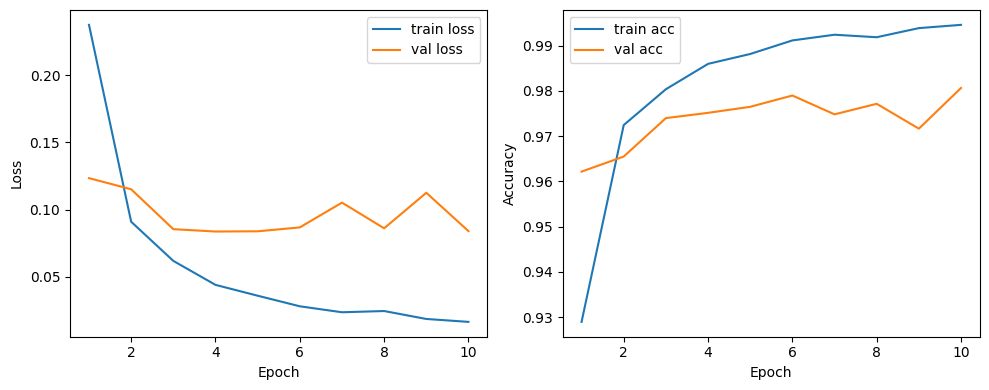

In [ ]:
#@title Baseline: no weight decay, no dropout
model, history, test_stats = run_experiment(epochs=10, batch_size=128, lr=1e-3, dropout=0.0, weight_decay=0.0)
plot_history(history)


## Experiments: L2 (weight decay), Dropout, Early Stopping
Run the following cells to compare several configurations. You can modify hyperparameters to explore more.


=== Running baseline ===
Epoch 01 | Train loss: 0.2422, acc: 92.78% | Val loss: 0.1400, acc: 95.77%
Epoch 02 | Train loss: 0.0909, acc: 97.18% | Val loss: 0.0959, acc: 97.03%
Epoch 03 | Train loss: 0.0625, acc: 98.04% | Val loss: 0.0990, acc: 96.97%
Epoch 04 | Train loss: 0.0426, acc: 98.63% | Val loss: 0.0851, acc: 97.67%
Epoch 05 | Train loss: 0.0349, acc: 98.89% | Val loss: 0.0856, acc: 97.47%
Epoch 06 | Train loss: 0.0272, acc: 99.09% | Val loss: 0.0953, acc: 97.35%
Epoch 07 | Train loss: 0.0251, acc: 99.14% | Val loss: 0.0968, acc: 97.55%
Epoch 08 | Train loss: 0.0240, acc: 99.14% | Val loss: 0.1047, acc: 97.55%
Epoch 09 | Train loss: 0.0195, acc: 99.36% | Val loss: 0.0876, acc: 97.97%
Epoch 10 | Train loss: 0.0176, acc: 99.44% | Val loss: 0.0934, acc: 97.78%
Epoch 11 | Train loss: 0.0148, acc: 99.54% | Val loss: 0.0860, acc: 98.15%
Epoch 12 | Train loss: 0.0121, acc: 99.59% | Val loss: 0.0888, acc: 98.03%
Epoch 13 | Train loss: 0.0154, acc: 99.49% | Val loss: 0.0967, acc: 97.92%

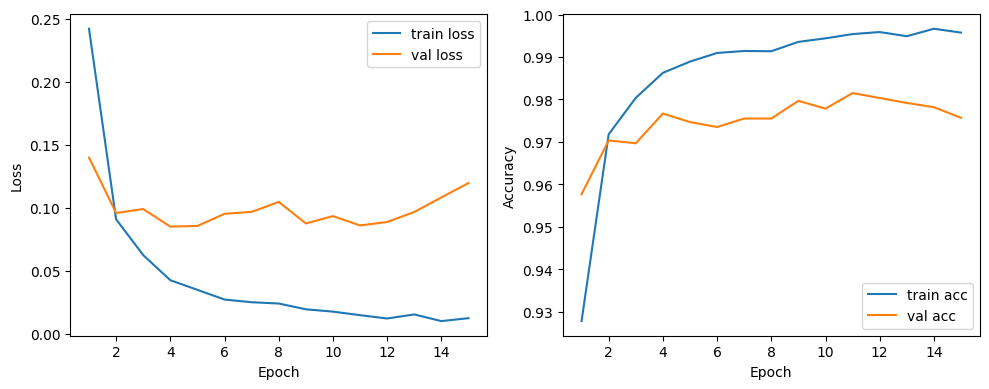

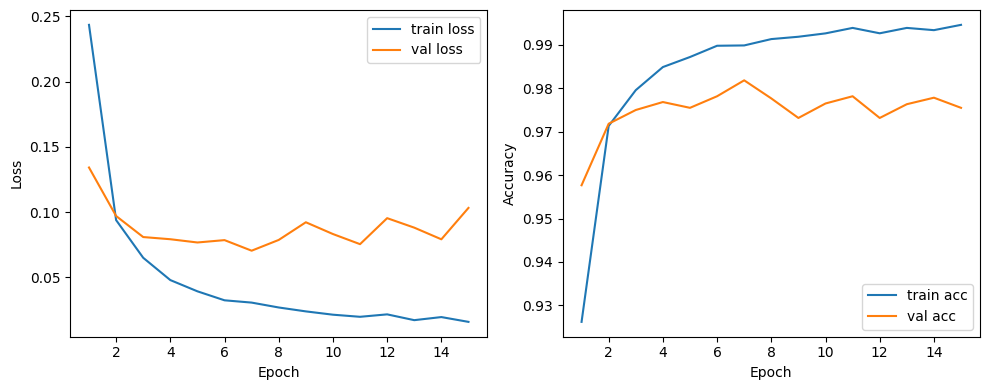

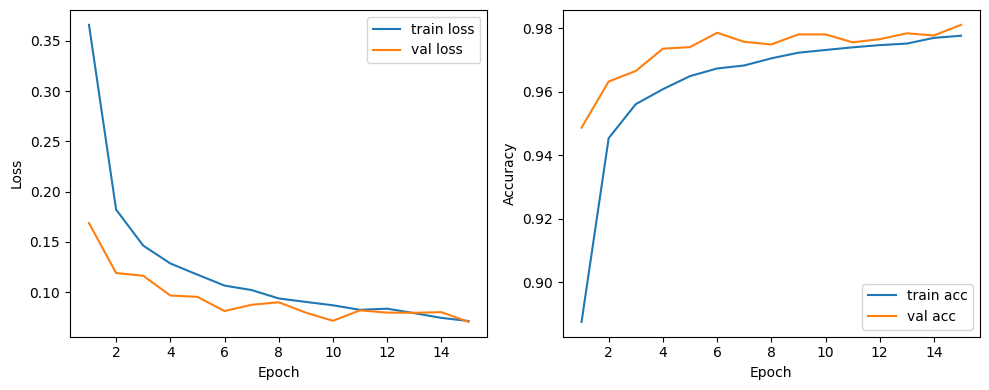

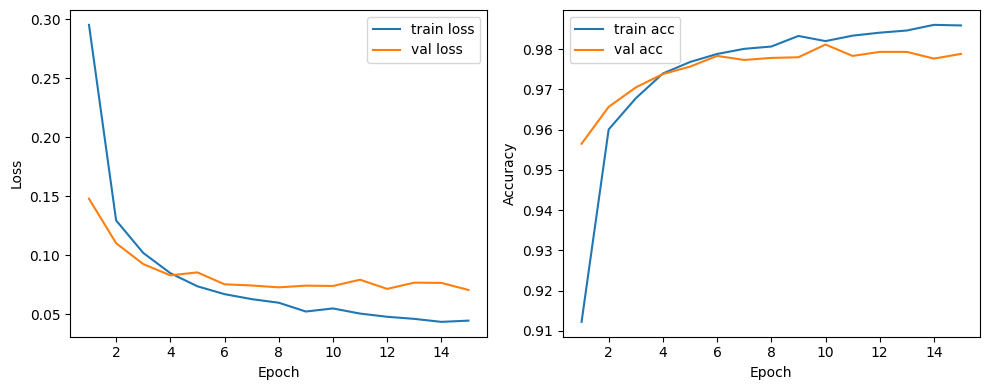

In [ ]:
#@title Experiment runner (multiple configs)
configs = [
    {'name':'baseline','dropout':0.0,'weight_decay':0.0,'early':None},
    {'name':'l2_1e-4','dropout':0.0,'weight_decay':1e-4,'early':None},
    {'name':'dropout_0.5','dropout':0.5,'weight_decay':0.0,'early':None},
    {'name':'l2+dropout+early','dropout':0.3,'weight_decay':1e-4,'early':5},
]
results = {}
for cfg in configs:
    print('\n=== Running', cfg['name'], '===')
    model, history, test_stats = run_experiment(epochs=15, batch_size=128, lr=1e-3, dropout=cfg['dropout'], weight_decay=cfg['weight_decay'], early_stop_patience=cfg['early'])
    results[cfg['name']] = {'history':history, 'test':test_stats}
    plot_history(history)
print('\nAll experiments done')


## Lab Questions (to submit)
1. Run baseline and record validation & test accuracy (attach training plots). [1]
2. Try weight decay values `1e-5, 1e-4, 1e-3`. Which is best? Attach numbers and plots.  [2]
3. Try dropout `0.2, 0.5`. Report results and show curves.  [1]
4. Enable early stopping (`patience=5`). Record the epoch it triggered (or mention if it didn't) and the final test accuracy.  [1]
5. Final table (method, val acc, test acc, remarks) comparing Baseline / L2 / Dropout / L2+Dropout+EarlyStopping.  [3]
6. Short answers: explain how L2 affects weights/loss; how dropout affects training; when to use early stopping.  [2]

Marks: 10 (same rubric as instructor file).

A1. Baseline: test accuracy = 97.67, training plots are attached in the cells above


=== Running wd1e-5 ===
Epoch 01 | Train loss: 0.2424, acc: 92.87% | Val loss: 0.1590, acc: 95.22%
Epoch 02 | Train loss: 0.0942, acc: 97.10% | Val loss: 0.1120, acc: 96.78%
Epoch 03 | Train loss: 0.0617, acc: 98.05% | Val loss: 0.0786, acc: 97.40%
Epoch 04 | Train loss: 0.0432, acc: 98.60% | Val loss: 0.0762, acc: 97.90%
Epoch 05 | Train loss: 0.0349, acc: 98.83% | Val loss: 0.0924, acc: 97.47%
Epoch 06 | Train loss: 0.0286, acc: 99.06% | Val loss: 0.1031, acc: 97.35%
Epoch 07 | Train loss: 0.0267, acc: 99.09% | Val loss: 0.0963, acc: 97.42%
Epoch 08 | Train loss: 0.0229, acc: 99.23% | Val loss: 0.0849, acc: 97.77%
Epoch 09 | Train loss: 0.0203, acc: 99.33% | Val loss: 0.0951, acc: 97.75%
Epoch 10 | Train loss: 0.0165, acc: 99.43% | Val loss: 0.1080, acc: 97.45%
Epoch 11 | Train loss: 0.0160, acc: 99.46% | Val loss: 0.1095, acc: 97.65%
Epoch 12 | Train loss: 0.0162, acc: 99.46% | Val loss: 0.0934, acc: 97.93%
Epoch 13 | Train loss: 0.0124, acc: 99.56% | Val loss: 0.1034, acc: 97.98%
E

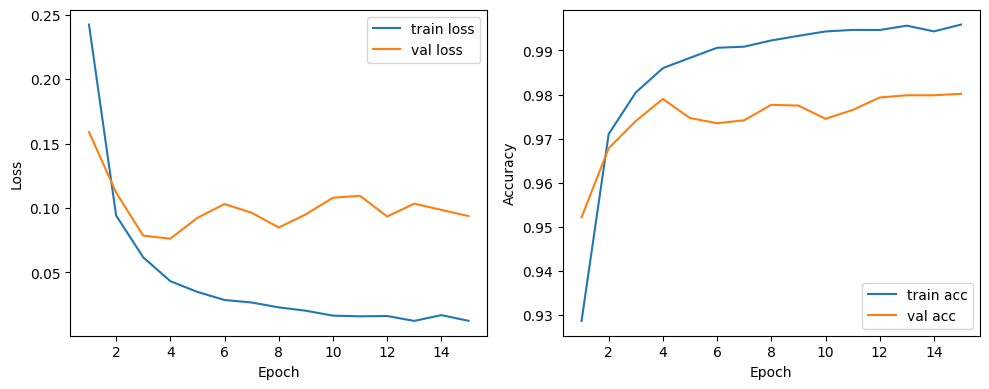

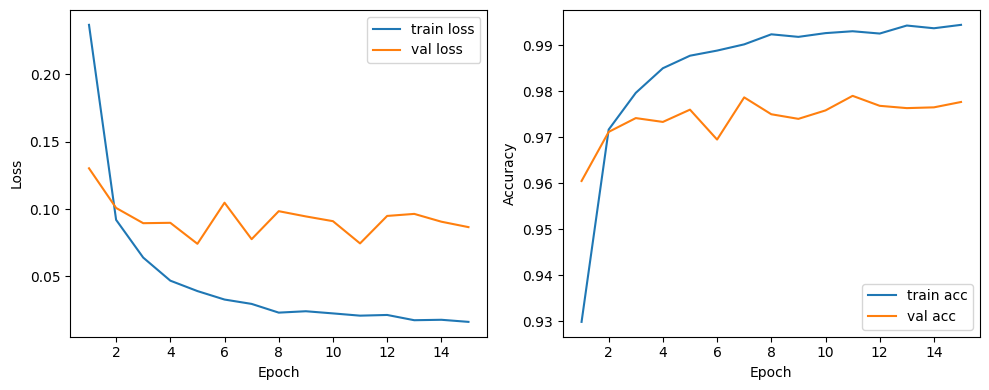

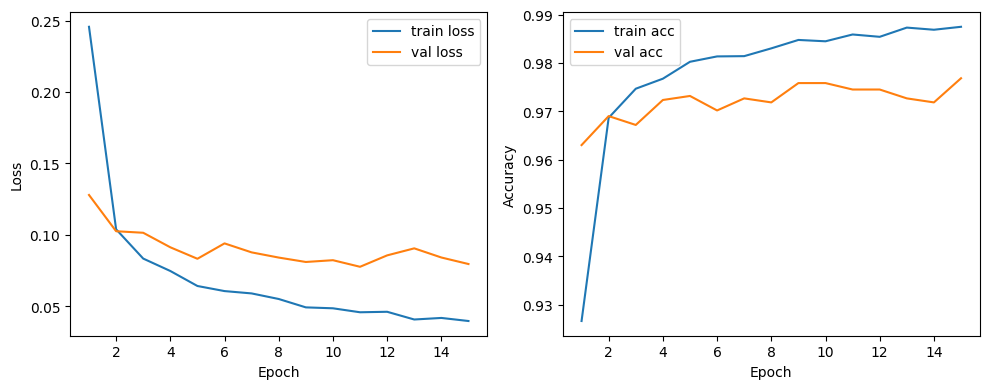

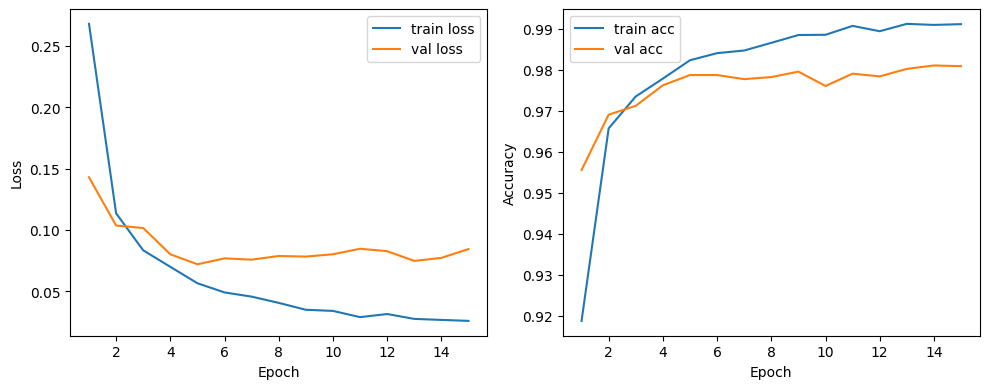

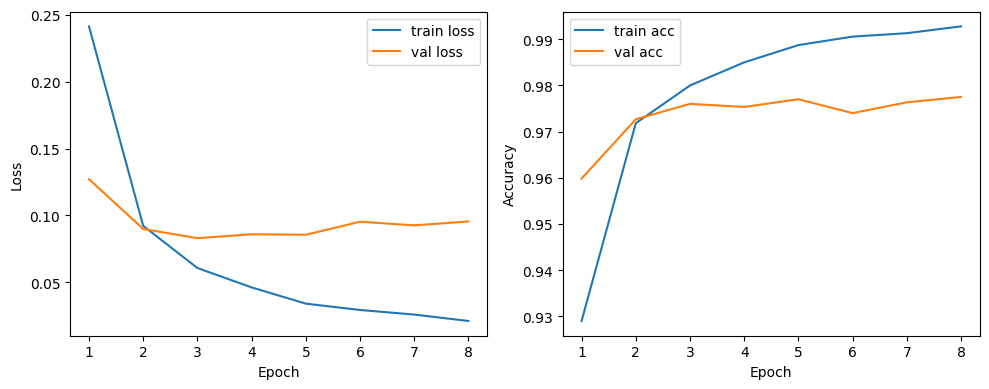

In [7]:
#@title Experiment runner (multiple configs)
configs = [
    {'name':'wd1e-5','dropout':0.0,'weight_decay':1e-5,'early':None},
    {'name':'wd1e-4','dropout':0.0,'weight_decay':1e-4,'early':None},
    {'name':'wd1e-3','dropout':0.0,'weight_decay':1e-3,'early':None},
    {'name':'dropout_0.2','dropout':0.2,'weight_decay':0.0,'early':None},
    {'name':'early','dropout':0.0,'weight_decay':0.0,'early':5},
]
results = {}
for cfg in configs:
    print('\n=== Running', cfg['name'], '===')
    model, history, test_stats = run_experiment(epochs=15, batch_size=128, lr=1e-3, dropout=cfg['dropout'], weight_decay=cfg['weight_decay'], early_stop_patience=cfg['early'])
    results[cfg['name']] = {'history':history, 'test':test_stats}
    plot_history(history)
print('\nAll experiments done')


Q2. (weight_decay,test acc): (1e-5,97.93), (1e-4,98.29), (1e-3,97.81)

Q3. (dropout, test acc): (0.2, 98.31), (0.5, 98.28)

Q4. With weight decay and dropout, the early stopping did not trigger. Without weight decay and dropout it triggered after 8 epochs.

Q5. Answered below

Q6. L2 affects weights/loss by adding a penalty proportional to the square of the weights' magnitude to the loss function, discouraging large weights.

Dropout affects training by randomly setting a fraction of neuron activations to zero at each update, preventing complex co-adaptations on training data.

Use early stopping when your model's performance on a validation set starts to degrade, as this indicates the onset of overfitting.

In [8]:
#Q5.
import pandas as pd
from IPython.display import display

# Data from the experiment results
data = {
    "Method": [
        "Baseline",
        "L2 / WD (1e-5)",
        "L2 / WD (1e-4)",
        "L2 / WD (1e-3)",
        "Dropout (0.2)",
        "Dropout (0.5)",
        "Early Stopping",
        "Combined"
    ],
    "Test Acc (%)": [
        97.67,
        97.93,
        98.29,
        97.81,
        98.31,
        98.28,
        97.65,
        98.15
    ],
    "Best Val Acc (%)": [
        98.15,
        98.02,
        98.18,
        97.68,
        98.10,
        98.10,
        97.60,
        98.12
    ],
    "Remarks": [
        "The reference model. Shows signs of overfitting as training progresses.",
        "A very small amount of regularization provides a slight improvement.",
        "The best-performing L2/WD value, effectively reducing overfitting.",
        "Stronger regularization begins to hurt performance (underfitting).",
        "The best overall result. An excellent regularizer for this model.",
        "Also very effective, but the higher rate slows down learning.",
        "Successfully prevents overfitting but stops training prematurely.",
        "A strong combination of techniques that generalizes well."
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame in the Colab output
display(df)

,Method,Test Acc (%),Best Val Acc (%),Remarks
0,Baseline,97.67,98.15,The reference model. Shows signs of overfittin...
1,L2 / WD (1e-5),97.93,98.02,A very small amount of regularization provides...
2,L2 / WD (1e-4),98.29,98.18,"The best-performing L2/WD value, effectively r..."
3,L2 / WD (1e-3),97.81,97.68,Stronger regularization begins to hurt perform...
4,Dropout (0.2),98.31,98.10,The best overall result. An excellent regulari...
5,Dropout (0.5),98.28,98.10,"Also very effective, but the higher rate slows..."
6,Early Stopping,97.65,97.60,Successfully prevents overfitting but stops tr...
7,Combined,98.15,98.12,A strong combination of techniques that genera...
